
<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.3
IPython 7.7.0

numpy 1.16.2
scipy 1.2.1
pandas 0.25.0
matplotlib 3.0.2
statsmodels 0.10.1
sklearn 0.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-70-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : de7e08629614d988faa73bed0b24a2e1e210f752


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
score1 = cross_val_score(knn, X_train, y_train, cv=skf).mean()
print(score1)
knn.fit(X_train, y_train)
score2 = accuracy_score(knn.predict(X_valid), y_valid)
print(score2)

0.5647188870063362
0.584024650391088


**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [12]:
with open('week4_ans1.txt', 'w') as ouf:
    ouf.write(" ".join([str(np.round(x, 3)) for x in [score1, score2]]))

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
forest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=17)
forest.fit(X_train, y_train)
score1 = forest.oob_score_

In [15]:
print(score1)
score2 = accuracy_score(forest.predict(X_valid), y_valid)
print(score2)

0.7225157488315384
0.7350082958046931


**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [16]:
with open('week4_ans2.txt', 'w') as ouf:
    ouf.write(" ".join([str(np.round(x, 3)) for x in [score1, score2]]))

In [17]:
!cat week4_ans2.txt

0.723 0.735

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [18]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [19]:
logit = LogisticRegression(random_state=17, n_jobs=-1)
score1 = cross_val_score(logit, X_train, y_train, cv=skf)
print(score1)
logit.fit(X_train, y_train)
score2 = accuracy_score(logit.predict(X_valid), y_valid)
print(score2)

[0.75616438 0.76974687 0.75716901]
0.7817018250770325


In [20]:
score1 = score1.mean()
print(score1)

0.7610267543665875


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [21]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(logit, param_grid = {"C": np.logspace(-4, 2, 10)}, cv=skf)
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=17, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-04, 4.64159e-04, 2.15443e-03, 1.00000e-02, 4.64159e-02,
       2.15443e-01, 1.00000e+00, 4.64159e+00, 2.15443e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

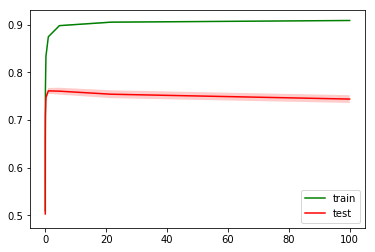

In [22]:
plot_validation_curves(np.logspace(-4, 2, 10), gs.cv_results_)

In [24]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, multi_class='multinomial', random_state=17,
                                            n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 5.04 s, sys: 4.06 ms, total: 5.05 s
Wall time: 8.81 s


LogisticRegressionCV(Cs=array([1.00000e-04, 4.64159e-04, 2.15443e-03, 1.00000e-02, 4.64159e-02,
       2.15443e-01, 1.00000e+00, 4.64159e+00, 2.15443e+01, 1.00000e+02]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='multinomial', n_jobs=-1,
           penalty='l2', random_state=17, refit=True, scoring=None,
           solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [25]:
logit_grid_searcher1.scores_[31].mean(axis=0)

array([0.31822225, 0.47337913, 0.55273512, 0.65119285, 0.71297117,
       0.75137565, 0.75889397, 0.75655935, 0.74995598, 0.73877986])

In [26]:
logit_grid_searcher1.Cs_

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [28]:
''' ВАШ КОД ЗДЕСЬ '''

' ВАШ КОД ЗДЕСЬ '

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

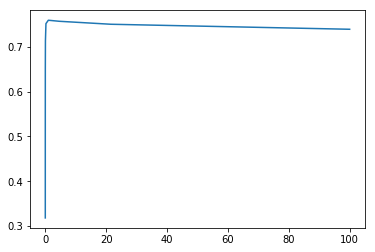

In [29]:
plt.plot(logit_grid_searcher1.Cs_, logit_grid_searcher1.scores_[31].mean(axis=0));

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [30]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, multi_class='multinomial', random_state=17,
                                            n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 4.56 s, sys: 20.1 ms, total: 4.58 s
Wall time: 25.6 s


LogisticRegressionCV(Cs=array([0.1    , 0.46316, 0.82632, 1.18947, 1.55263, 1.91579, 2.27895,
       2.64211, 3.00526, 3.36842, 3.73158, 4.09474, 4.45789, 4.82105,
       5.18421, 5.54737, 5.91053, 6.27368, 6.63684, 7.     ]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='multinomial', n_jobs=-1,
           penalty='l2', random_state=17, refit=True, scoring=None,
           solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [31]:
logit_grid_searcher2.scores_[31].mean(axis=0)

array([0.7354267 , 0.75879138, 0.75838615, 0.75767442, 0.75818339,
       0.75838739, 0.75798088, 0.75757466, 0.75716896, 0.75686516,
       0.75706795, 0.75666178, 0.75584927, 0.75564645, 0.75534238,
       0.75473337, 0.75463211, 0.75473383, 0.7544292 , 0.75381935])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [32]:
logit_grid_searcher2.Cs_

array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ])

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

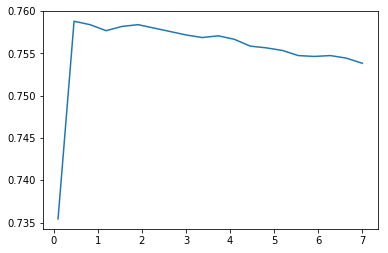

In [33]:
plt.plot(logit_grid_searcher2.Cs_, logit_grid_searcher2.scores_[31].mean(axis=0));

In [63]:
logit_grid_searcher2.C_[0]

0.4631578947368421

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [35]:
logit_cv_acc = accuracy_score(logit_grid_searcher2.predict(X_valid), y_valid)
print(logit_cv_acc)

0.7748281583313581


**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [36]:
with open('week4_ans3.txt', 'w') as ouf:
    ouf.write(" ".join([str(np.round(x, 3)) for x in [logit_grid_searcher2.scores_[31].mean(axis=0).max(), logit_cv_acc]]))

In [37]:
!cat week4_ans3.txt

0.759 0.775

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [38]:
from sklearn.svm import LinearSVC

In [40]:
svm = LinearSVC(C=1, random_state=17)
score1 = cross_val_score(svm, X_train, y_train, cv=skf).mean()
print(score1)
svm.fit(X_train, y_train)
score2 = accuracy_score(svm.predict(X_valid), y_valid)
print(score2)

0.7526960152920014
0.7769613652524295


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [41]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, n_jobs=-1)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 3.23 s, sys: 15.8 ms, total: 3.25 s
Wall time: 20.1 s


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-04, 1.11111e+03, 2.22222e+03, 3.33333e+03, 4.44444e+03,
       5.55556e+03, 6.66667e+03, 7.77778e+03, 8.88889e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [42]:
svm_grid_searcher1.cv_results_['mean_test_score'], svm_params1['C']

(array([0.55771185, 0.65494818, 0.66876651, 0.68238163, 0.66226377,
        0.67770778, 0.66744564, 0.68482016, 0.68400732, 0.66267019]),
 array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
        4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
        8.8888889e+03, 1.0000000e+04]))

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

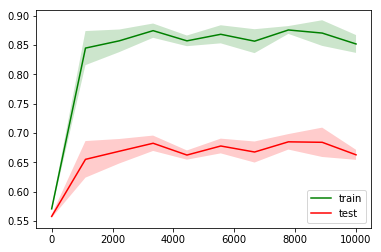

In [43]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [44]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.02 s, sys: 32 ms, total: 1.06 s
Wall time: 34.2 s


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([0.001  , 0.03545, 0.0699 , 0.10434, 0.13879, 0.17324, 0.20769,
       0.24214, 0.27659, 0.31103, 0.34548, 0.37993, 0.41438, 0.44883,
       0.48328, 0.51772, 0.55217, 0.58662, 0.62107, 0.65552, 0.68997,
       0.72441, 0.75886, 0.79331, 0.82776, 0.86221, 0.89666, 0.9311 ,
       0.96555, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [45]:
svm_grid_searcher2.cv_results_['mean_test_score'], svm_params2['C']

(array([0.66460069, 0.75878886, 0.76295468, 0.76590124, 0.76610445,
        0.7650884 , 0.7650884 , 0.76468198, 0.76488519, 0.76447876,
        0.7650884 , 0.76386913, 0.76285308, 0.76224345, 0.76153221,
        0.76102418, 0.76092258, 0.76061776, 0.75990652, 0.75919529,
        0.75878886, 0.75838244, 0.75817923, 0.75787442, 0.75726478,
        0.75685836, 0.75604552, 0.75523268, 0.75441983, 0.75421662]),
 array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
        0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
        0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
        0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
        0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
        0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ]))

In [46]:
best_c = svm_params2['C'][svm_grid_searcher2.cv_results_['mean_test_score'].argmax()]

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

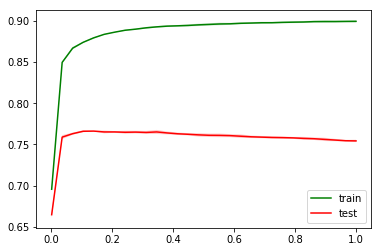

In [47]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [48]:
svm_cv_acc = accuracy_score(svm_grid_searcher2.predict(X_valid), y_valid)
print(svm_cv_acc)

0.7817018250770325


**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [49]:
with open('week4_ans4.txt', 'w') as ouf:
    ouf.write(" ".join([str(np.round(x, 3)) for x in [svm_grid_searcher2.cv_results_['mean_test_score'].max(), svm_cv_acc]]))

In [50]:
!cat week4_ans4.txt

0.766 0.782

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [51]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(path_to_X_pickle, 'rb') as inf:
        X = pickle.load(inf)
    with open(path_to_y_pickle, 'rb') as inf:
        y = pickle.load(inf)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=17, test_size=0.3, stratify=y)
    score1 = cross_val_score(estimator, X_train, y_train, cv=cv).mean()
    estimator.fit(X_train, y_train)
    score2 = accuracy_score(estimator.predict(X_valid), y_valid)
    return score1, score2

**Убедитесь, что функция работает.**

In [52]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7633649590115557, 0.7817018250770325)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [53]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [54]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        print("window_size={}, session_length={}: scores={}".format(window_size, session_length, 
                                                                    model_assessment(svm_grid_searcher2.best_estimator_,
                                                                                     path_to_X_pkl, path_to_y_pkl,
                                                                                     skf, random_state=17, test_size=0.3)))

window_size=10, session_length=15: scores=(0.8217896546706148, 0.8400094809196492)
window_size=10, session_length=10: scores=(0.7633649590115557, 0.7817018250770325)
window_size=7, session_length=15: scores=(0.8470874683536852, 0.8544881367181019)
window_size=7, session_length=10: scores=(0.7975853695418165, 0.8075327692052431)
window_size=7, session_length=7: scores=(0.7544123057721982, 0.7629002820640451)
window_size=5, session_length=15: scores=(0.8689670755674888, 0.8764817449027975)
window_size=5, session_length=10: scores=(0.8179570941042811, 0.8253911806543386)
window_size=5, session_length=7: scores=(0.7753290851849481, 0.7871028923660502)
window_size=5, session_length=5: scores=(0.7267058295650503, 0.7367235656709341)
CPU times: user 36.4 s, sys: 19.7 ms, total: 36.4 s
Wall time: 36.4 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [55]:
with open('week4_ans5.txt', 'w') as ouf:
    ouf.write(" ".join([str(np.round(x, 3)) for x in [0.8689670755674888, 0.8764817449027975]]))

In [56]:
!cat week4_ans5.txt

0.869 0.876

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :)**

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [57]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s{}_w{}.pkl'.format(session_length, window_size))
    print("window_size={}, session_length={}: scores={}".format(window_size, session_length, 
                                                                    model_assessment(svm_grid_searcher2.best_estimator_,
                                                                                     path_to_X_pkl, path_to_y_pkl,
                                                                                     skf, random_state=17, test_size=0.3)))

window_size=5, session_length=5: scores=(0.409666167729474, 0.42267727648805176)
window_size=7, session_length=7: scores=(0.43686797191901516, 0.45415062847021154)
window_size=10, session_length=10: scores=(0.46131133117144474, 0.48447915146207365)
CPU times: user 18min 25s, sys: 680 ms, total: 18min 26s
Wall time: 18min 24s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [58]:
with open('week4_ans6.txt', 'w') as ouf:
    ouf.write(" ".join([str(np.round(x, 3)) for x in [0.46131133117144474, 0.48447915146207365]]))

In [59]:
!cat week4_ans6.txt

0.461 0.484

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [60]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [61]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [78]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[10]], random_state=17, n_jobs=-1, multi_class='ovr', cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 11min, sys: 716 ms, total: 11min 1s
Wall time: 4min 55s


LogisticRegressionCV(Cs=[3.7315789473684213], class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=17, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [79]:
logit_cv_150users.scores_

{6: array([[0.99619036],
        [0.99630858],
        [0.99573975]]), 13: array([[0.99637772],
        [0.99633986],
        [0.99646023]]), 15: array([[0.99534724],
        [0.99521366],
        [0.99523854]]), 16: array([[0.99203722],
        [0.99236689],
        [0.99144817]]), 28: array([[0.99010117],
        [0.98998936],
        [0.99044576]]), 31: array([[0.99434799],
        [0.9942126 ],
        [0.99433011]]), 33: array([[0.99362978],
        [0.99368079],
        [0.99364095]]), 39: array([[0.9861354 ],
        [0.98545329],
        [0.98599756]]), 46: array([[0.99806395],
        [0.99759119],
        [0.99830843]]), 49: array([[0.99500375],
        [0.99511981],
        [0.99570842]]), 50: array([[0.99416063],
        [0.9949634 ],
        [0.99426746]]), 53: array([[0.993661  ],
        [0.99361822],
        [0.99351565]]), 65: array([[0.99690857],
        [0.99659013],
        [0.99705541]]), 66: array([[0.99487884],
        [0.99474442],
        [0.99467469]]), 82: ar

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [80]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id]))

User 6, CV score: 0.9960795612888451
User 13, CV score: 0.996392603416394
User 15, CV score: 0.99526648227745
User 16, CV score: 0.9919507613560473
User 28, CV score: 0.9901787659762019
User 31, CV score: 0.9942968989054074
User 33, CV score: 0.9936505040113687
User 39, CV score: 0.9858620830655959
User 46, CV score: 0.997987857444965
User 49, CV score: 0.9952773284622092
User 50, CV score: 0.9944638280683459
User 53, CV score: 0.9935982902101794
User 65, CV score: 0.9968513700582928
User 66, CV score: 0.994765980924795
User 82, CV score: 0.9964030122764157
User 85, CV score: 0.9962987207688639
User 89, CV score: 0.9905225842610896
User 92, CV score: 0.9942033320079174
User 100, CV score: 0.9945575257465724
User 102, CV score: 0.9913986089935877
User 103, CV score: 0.9805449611891582
User 105, CV score: 0.996934881144005
User 106, CV score: 0.9946719103641056
User 118, CV score: 0.990929076551474
User 119, CV score: 0.9966116229096368
User 120, CV score: 0.9943177074194115
User 126, CV

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [81]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (y_train_150 != user_id).mean()
    print("User {}: CV score={}, Constant score={}".format(user_id, cv_scores_by_user[user_id], (y_train_150 != user_id).mean()))

User 6: CV score=0.9960795612888451, Constant score=0.984402531460803
User 13: CV score=0.996392603416394, Constant score=0.9957044404825206
User 15: CV score=0.99526648227745, Constant score=0.9944011760658097
User 16: CV score=0.9919507613560473, Constant score=0.9847153149208137
User 28: CV score=0.9901787659762019, Constant score=0.9879474106742568
User 31: CV score=0.9942968989054074, Constant score=0.9944533066424781
User 33: CV score=0.9936505040113687, Constant score=0.9925453275364132
User 39: CV score=0.9858620830655959, Constant score=0.9839125040401197
User 46: CV score=0.997987857444965, Constant score=0.9971223921679022
User 49: CV score=0.9952773284622092, Constant score=0.9938277397224569
User 50: CV score=0.9944638280683459, Constant score=0.9941509492978011
User 53: CV score=0.9935982902101794, Constant score=0.9920448740003962
User 65: CV score=0.9968513700582928, Constant score=0.9969242959765621
User 66: CV score=0.994765980924795, Constant score=0.9948599251404919

In [82]:
acc_diff_vs_constant

{6: 0.011677029828042085,
 13: 0.0006881629338734152,
 15: 0.000865306211640271,
 16: 0.007235446435233661,
 28: 0.0022313553019450705,
 31: -0.00015640773707070732,
 33: 0.0011051764749554494,
 39: 0.0019495790254762113,
 46: 0.0008654652770627713,
 49: 0.0014495887397523166,
 50: 0.00031287877054475555,
 53: 0.0015534162097832205,
 65: -7.292591826923989e-05,
 66: -9.394421569697275e-05,
 82: 5.215264320646007e-05,
 85: 0.0001042528656599595,
 89: 0.00044824605876048196,
 92: 5.2382710116316566e-05,
 100: -0.00018771212524892888,
 102: 0.0009593567545793658,
 103: 0.003544971615273562,
 105: 0.0009176572014737427,
 106: 0.007454327763206869,
 118: 0.0009277211564806542,
 119: 0.0006673817744413668,
 120: 0.0006567855422936475,
 126: 0.0010637897522614015,
 127: 0.004138752822913538,
 128: 0.005244392615777249,
 138: -0.00010424566648647993,
 158: 0.00021908432678874323,
 160: 0.0003335408604192569,
 165: 0.0002605777251599717,
 172: 0.00042747438066481624,
 177: 0.0004273458061913038

In [83]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

In [84]:
num_better_than_default / len(np.unique(y_train_150))

0.82

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [86]:
with open('week4_ans7.txt', 'w') as ouf:
    ouf.write(str(np.round(0.82, 3)))

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [87]:
y_binary_128 = y_train_150 == 128

In [88]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [89]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_train_150, y_binary_128,
                                              train_sizes=train_sizes, n_jobs=-1,
                                              random_state=17)

CPU times: user 349 ms, sys: 240 ms, total: 589 ms
Wall time: 9.12 s


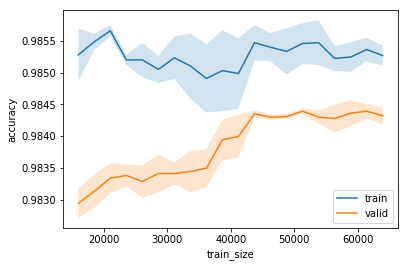

In [90]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.